# RNNs para detectar preguntas duplicadas

### Procesamiento del Lenguaje Natural

**Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

En este último notebook, vamos a trabajar de nuevo con un conjunto reducido de entradas la base de datos [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/data), que incluye pares de preguntas etiquetadas como duplicadas. Utilizaremos como baseline la solución del proyecto 3 y veremos cómo podemos mejorar significativamente utilizando RNNs para proyectar cada una de las dos preguntas en un espacio en el que un clasificador determinará si ambas preguntas son duplicadas o no.



## 1. Preprocesado

Vamos a cargar la base de datos e implementar los baselines ...

In [1]:
import pandas as pd

df = pd.read_csv("http://www.tsc.uc3m.es/~olmos/BBVA/QUORA_DUPLICATES.csv")

In [2]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,Where can I buy a Diamond?,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


Extraemos las primeras 20.000 entradas de la base de datos y separamos el dataset en entrenamiento (80%) y test (20%).

In [3]:
df_red = df.iloc[:20000].copy()

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(df_red[['question1','question2']], df_red['is_duplicate'], test_size=0.2, random_state=0)

df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=0)

<AxesSubplot:>

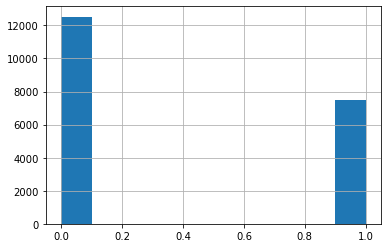

In [5]:
df_red['is_duplicate'].hist()

In [6]:
accuracy_baseline = 1-y_train.sum()/y_train.shape[0]

print(f"Un clasificador que siempre prediga que las preguntas son distintas acierta el {accuracy_baseline*100} de las veces")

Un clasificador que siempre prediga que las preguntas son distintas acierta el 62.3984375 de las veces


Vectorice las preguntas usando tanto TF-IDF como promedio de word embeddings. Concatenamos la representación de cada par de preguntas en el conjunto de entrenamiento y test.

In [7]:
import spacy

nlp = spacy.load("en_core_web_lg")

questions_pairs_train = [(nlp(q1),nlp(q2)) for (q1,q2) in df_train[["question1","question2"]].values]
questions_pairs_val = [(nlp(q1),nlp(q2)) for (q1,q2) in df_val[["question1","question2"]].values]
questions_pairs_test = [(nlp(q1),nlp(q2)) for (q1,q2) in df_test[["question1","question2"]].values]


In [8]:
def normalize(doc):
    
    return [w for w in doc if not w.is_stop and w.has_vector and not w.is_punct]

# eliminamos stopping words, puntuaciones y tokens sin word embedding
norm_questions_pairs_train = [(normalize(q1),normalize(q2)) for (q1,q2) in questions_pairs_train]
norm_questions_pairs_val = [(normalize(q1),normalize(q2)) for (q1,q2) in questions_pairs_val]
norm_questions_pairs_test = [(normalize(q1),normalize(q2)) for (q1,q2) in questions_pairs_test]

# Pasamos a modo texto

norm_question_pairs_train_text = [([w.text.lower() for w in q1],[w.text.lower() for w in q2]) for (q1,q2) in norm_questions_pairs_train]
norm_question_pairs_val_text = [([w.text.lower() for w in q1],[w.text.lower() for w in q2]) for (q1,q2) in norm_questions_pairs_val]
norm_question_pairs_test_text = [([w.text.lower() for w in q1],[w.text.lower() for w in q2]) for (q1,q2) in norm_questions_pairs_test]

In [9]:
# Calculamos la media de los WE
import numpy as np

W_train = np.array([[nlp(' '.join(q1)).vector,nlp(' '.join(q2)).vector] for (q1,q2) in norm_question_pairs_train_text]).reshape([len(norm_question_pairs_train_text),600])

W_val = np.array([[nlp(' '.join(q1)).vector,nlp(' '.join(q2)).vector] for (q1,q2) in norm_question_pairs_val_text]).reshape([len(norm_question_pairs_val_text),600])

W_test = np.array([[nlp(' '.join(q1)).vector,nlp(' '.join(q2)).vector] for (q1,q2) in norm_question_pairs_test_text]).reshape([len(norm_question_pairs_test_text),600])



In [10]:

print(f"La matriz de embeddings de entrenamiento W_train tiene dimensiones {W_train.shape}")

print(f"La matriz de embeddings de test W_train tiene dimensiones {W_test.shape}")

La matriz de embeddings de entrenamiento W_train tiene dimensiones (12800, 600)
La matriz de embeddings de test W_train tiene dimensiones (4000, 600)


In [11]:
# Diccionario y TF-IDF

import gensim
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc


D = gensim.corpora.Dictionary([item for s in norm_question_pairs_train_text for item in s])

no_below = 10 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)

corpus_bow_train_q1 = [D.doc2bow(q1) for (q1,q2) in norm_question_pairs_train_text]
corpus_bow_train_q2 = [D.doc2bow(q2) for (q1,q2) in norm_question_pairs_train_text]

corpus_bow_test_q1 = [D.doc2bow(q1) for (q1,q2) in norm_question_pairs_test_text]
corpus_bow_test_q2 = [D.doc2bow(q2) for (q1,q2) in norm_question_pairs_test_text]

model = TfidfModel(corpus_bow_train_q1+corpus_bow_train_q2)  

corpus_tfidf_train_q1 = model[corpus_bow_train_q1]
corpus_tfidf_train_q2 = model[corpus_bow_train_q2]

corpus_tfidf_test_q1 = model[corpus_bow_test_q1]
corpus_tfidf_test_q2 = model[corpus_bow_test_q2]

n_tokens = len(D)

# Convert TFIDF representacion
C1_train = corpus2dense(corpus_tfidf_train_q1, num_terms=n_tokens, num_docs=len(corpus_bow_train_q1)).T
C2_train = corpus2dense(corpus_tfidf_train_q2, num_terms=n_tokens, num_docs=len(corpus_bow_train_q2)).T

C1_test = corpus2dense(corpus_tfidf_test_q1, num_terms=n_tokens, num_docs=len(corpus_bow_test_q1)).T
C2_test = corpus2dense(corpus_tfidf_test_q2, num_terms=n_tokens, num_docs=len(corpus_bow_test_q2)).T

C_train = np.hstack((C1_train,C2_train))

C_test = np.hstack((C1_test,C2_test))


In [12]:
print(f"La matriz TF-IDF de entrenamiento C_train tiene dimensiones {C_train.shape}")

print(f"La matriz TF-IDF de test C_test tiene dimensiones {C_test.shape}")

La matriz TF-IDF de entrenamiento C_train tiene dimensiones (12800, 4708)
La matriz TF-IDF de test C_test tiene dimensiones (4000, 4708)


## 2. Clasificador LR con TF-IDF/media embeddings concatenadas

Entrenamos ahora un clasificador de tipo regresión logística utilizando a la entrada la concatenación de ambas preguntas.

In [13]:
# Entrenamiento RL con TF-IDF

from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV

rango_C = np.logspace(-3, 3, 10)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

LR_with_CV  = GridSearchCV(estimator=LR(max_iter=1e04),
                                  param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
LR_with_CV.fit(C_train,y_train)   

print("El mejor parámetro C es {0:.2f}".format(LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = LR_with_CV.score(C_train,y_train)   
accuracy_test = LR_with_CV.score(C_test,y_test)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))


El mejor parámetro C es 0.46
Accuracy train 76.34%. Accuracy test 68.08%



In [14]:
# Entrenamiento RL con WE

from sklearn.preprocessing import StandardScaler

# A diferencia de TF-IDF, en este caso normalizamos las características (columnas de W)

transformer = StandardScaler().fit(W_train)   

W_train_norm = transformer.transform(W_train)
W_test_norm = transformer.transform(W_test)


rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

emb_LR_with_CV = GridSearchCV(estimator=LR(penalty='l2',max_iter=1e04),param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
emb_LR_with_CV.fit(W_train_norm,y_train)   

print("El mejor parámetro C es {0:.2f}".format(emb_LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = emb_LR_with_CV.score(W_train_norm,y_train)   
accuracy_test = emb_LR_with_CV.score(W_test_norm,y_test)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))



El mejor parámetro C es 0.00
Accuracy train 69.73%. Accuracy test 67.53%



Como vemos, ambos clasificadores apenas mejoran el baseline ...

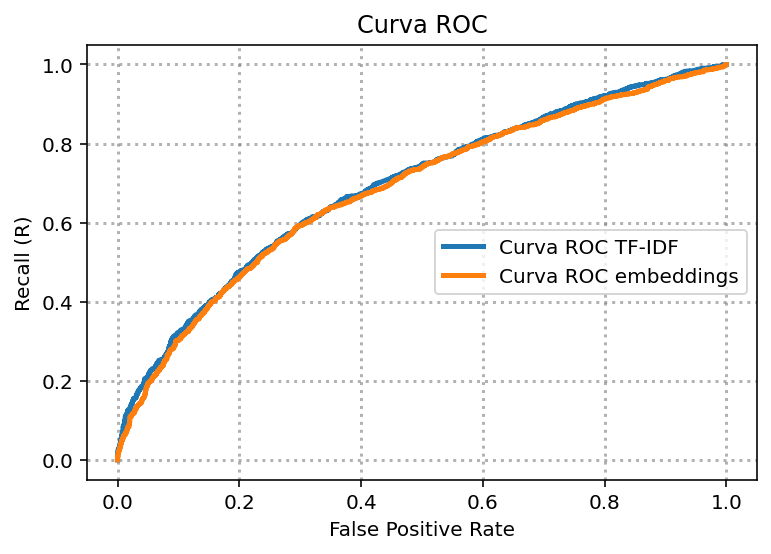

El área bajo la curva ROC de TF-IDF es 0.6915149345335515
El área bajo la curva ROC de embeddings es 0.6828903639440125


In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt

from sklearn import metrics
fpr, recall, thresholds = metrics.roc_curve(y_test, LR_with_CV.predict_proba(C_test)[:,1], pos_label=1) 
fpr2, recall2, thresholds = metrics.roc_curve(y_test, emb_LR_with_CV.predict_proba(W_test_norm)[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_tf_idf = metrics.roc_auc_score(y_test, LR_with_CV.predict_proba(C_test)[:,1]) 
area_roc_embbedings = metrics.roc_auc_score(y_test, emb_LR_with_CV.predict_proba(W_test_norm)[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")

## 2. Clasificación usando k-NN y distancia coseno

Usamos tanto WE como TF-IDF ...

In [16]:

norms = np.linalg.norm(C_train,axis=1)

norms[norms<1e-6] = 1e-6

C_train_ = C_train/norms.reshape([-1,1])

norms = np.linalg.norm(C_test,axis=1)

norms[norms<1e-6] = 1e-6

C_test_ = C_test/norms.reshape([-1,1])


In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenamiento k-NN con validación de vecinos y ponderación de distancias
K_max = 15
rango_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
diccionario_parametros = [{'n_neighbors': rango_K,'weights':['uniform','distance']}]

# Validación cruzada con GridSearchCV
knn = GridSearchCV(estimator=KNeighborsClassifier( ), param_grid=diccionario_parametros,cv=nfold)
# Entrenamiento
knn.fit(C_train_,y_train)
# Test
accuracy_train_knn = knn.score(C_train_,y_train)
accuracy_test_knn = knn.score(C_test_,y_test)

print("El número de vecinos seleccionado es k={0:d}".format(knn.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))

El número de vecinos seleccionado es k=2
Accuracy train 98.91%. Accuracy test 69.10%



In [18]:
# Embeddings

norms = np.linalg.norm(W_train,axis=1)

norms[norms<1e-6] = 1e-6

W_train_ = W_train/norms.reshape([-1,1])

norms = np.linalg.norm(W_test,axis=1)

norms[norms<1e-6] = 1e-6

W_test_ = W_test/norms.reshape([-1,1])

In [19]:
# Entrenamiento k-NN con validación de vecinos y ponderación de distancias
K_max = 15
rango_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
diccionario_parametros = [{'n_neighbors': rango_K,'weights':['uniform','distance']}]

# Validación cruzada con GridSearchCV
emb_knn = GridSearchCV(estimator=KNeighborsClassifier( ), param_grid=diccionario_parametros,cv=nfold)
# Entrenamiento
emb_knn.fit(W_train_,y_train)
# Test
accuracy_train_knn = emb_knn.score(W_train_,y_train)
accuracy_test_knn =emb_knn.score(W_test_,y_test)

print("El número de vecinos seleccionado es k={0:d}".format(emb_knn.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))

El número de vecinos seleccionado es k=12
Accuracy train 74.14%. Accuracy test 67.33%



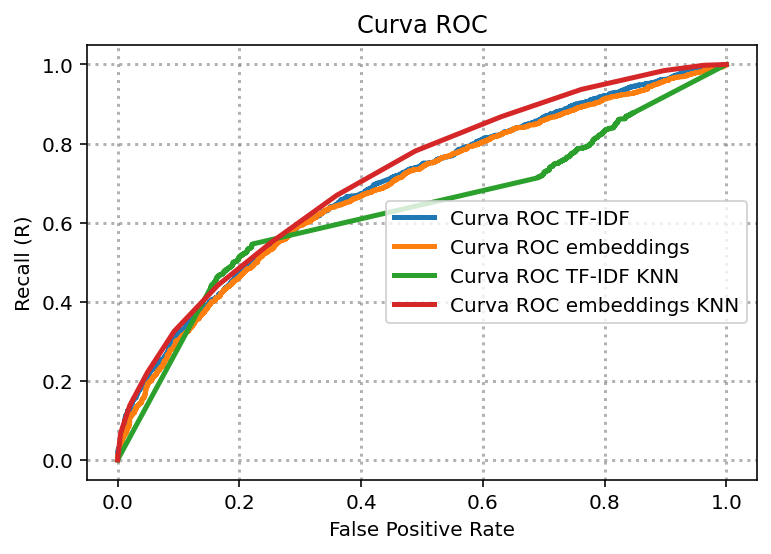

El área bajo la curva ROC de TF-IDF es 0.6915149345335515
El área bajo la curva ROC de embeddings es 0.6828903639440125
El área bajo la curva ROC de TF-IDF con KNN es 0.6306828958248091
El área bajo la curva ROC de embeddings con KNN es 0.7164617643548827


In [20]:
fpr3, recall3, thresholds = metrics.roc_curve(y_test, knn.predict_proba(C_test_)[:,1], pos_label=1) 
fpr4, recall4, thresholds = metrics.roc_curve(y_test, emb_knn.predict_proba(W_test_)[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC TF-IDF KNN')
plt.plot(fpr4,recall4,lw=2.5,label='Curva ROC embeddings KNN')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_tf_idf_KNN = metrics.roc_auc_score(y_test, knn.predict_proba(C_test_)[:,1]) 
area_roc_embbedings_KNN = metrics.roc_auc_score(y_test, emb_knn.predict_proba(W_test_)[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de TF-IDF con KNN es {area_roc_tf_idf_KNN}")
print(f"El área bajo la curva ROC de embeddings con KNN es {area_roc_embbedings_KNN}")

# 3. Clasficiación usndo una red RNN siamesa

Implementamos el siguiente esquema

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN_siamese.png' width=800 />


Podemos comprobar cómo si $H$ es la dimensión del estado latente, la entrada al clasificador es un vector de dimensión $2H+1$: la diferencia elemento a elemento, el producto elemento a elemento, y la norma del vector diferencia. Podeis comprobar cómo estas características no ayudan especialmente a los baselines anteriores. 

Para acelerar el entrenamiento, vamos a procesar únicamente los **20 primeros tokens de cada pregunta**. Si la pregunta tiene menos longitud, añadimos tokens "basura". 

In [21]:
max_l = 30

# Longitud por pregunta, saturando en max_l

l1_train = [np.min([len(q1),max_l]) for (q1,q2) in norm_questions_pairs_train]
l2_train = [np.min([len(q2),max_l]) for (q1,q2) in norm_questions_pairs_train]

l1_val = [np.min([len(q1),max_l]) for (q1,q2) in norm_questions_pairs_val]
l2_val = [np.min([len(q2),max_l]) for (q1,q2) in norm_questions_pairs_val]

l1_test = [np.min([len(q1),max_l]) for (q1,q2) in norm_questions_pairs_test]
l2_test = [np.min([len(q2),max_l]) for (q1,q2) in norm_questions_pairs_test]

In [22]:
# Igualar dataset añadiendo garbage tokens (no se tendrán en cuenta)

garbage_token = nlp('#')

norm_questions_pairs_train_eq_length = [(q1[:max_l]+[garbage_token]*(np.max([0,max_l-len(q1)])),q2[:max_l]+[garbage_token]*(np.max([0,max_l-len(q2)]))) for (q1,q2) in norm_questions_pairs_train]
docs_train_1 = [q1 for (q1,q2) in norm_questions_pairs_train_eq_length]
docs_train_2 = [q2 for (q1,q2) in norm_questions_pairs_train_eq_length]

norm_questions_pairs_val_eq_length = [(q1[:max_l]+[garbage_token]*(np.max([0,max_l-len(q1)])),q2[:max_l]+[garbage_token]*(np.max([0,max_l-len(q2)]))) for (q1,q2) in norm_questions_pairs_val]
docs_val_1 = [q1 for (q1,q2) in norm_questions_pairs_val_eq_length]
docs_val_2 = [q2 for (q1,q2) in norm_questions_pairs_val_eq_length]


norm_questions_pairs_test_eq_length = [(q1[:max_l]+[garbage_token]*(np.max([0,max_l-len(q1)])),q2[:max_l]+[garbage_token]*(np.max([0,max_l-len(q2)]))) for (q1,q2) in norm_questions_pairs_test]
docs_test_1 = [q1 for (q1,q2) in norm_questions_pairs_test_eq_length]
docs_test_2 = [q2 for (q1,q2) in norm_questions_pairs_test_eq_length]

In [23]:
import torch
from torch import nn
from torch import optim

Definimos la red RNN. Dado lo comentado en el notebook de análisis de opinión, no hay mucha novedad aquí ...

In [24]:
class Siamese_RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, h2, n_layers,prob=0.5):
        
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size

        # RNN

        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=0.0, batch_first=True)
        
        # Clasificador MLP con dos capas
        self.fc1 = nn.Linear(2*hidden_dim+1,h2)
        
        self.fc2 = nn.Linear(h2,1)
        
        self.sigmoid = nn.Sigmoid() 
        
        self.tanh = nn.Tanh()
        
        self.dropout = nn.Dropout(p=prob)

    def forward(self,x1,x2,lengths1,lengths2,h0=None):
        
        
        batch_size = x1.size(0) # Number of signals N
        seq_length = x2.size(1) # T
        
        # Obtenemos la salia de la RNN para ambas preguntas
        r1_out, _ = self.rnn(x1, h0)
        
        r2_out, _ = self.rnn(x2, h0)
        
        # Para cada una, obtenemos el estado tras procesar el último token real, sin tener en cuentta los token basura añadidos
        
        aux1=torch.stack([r1_out[d,lengths1[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        
        aux2=torch.stack([r2_out[d,lengths2[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        
        # Obtenemos las características del clasificador ...
        
        v1 = torch.abs(aux1-aux2) # Diferencia elemento a elemento
        
        v2 = aux1 * aux2 # Producto elemento a elemento
        
        v3 = torch.norm(aux1-aux2,1,1).reshape([-1,1]) # Norma vector diferencia
        
        v4 = torch.cat([v1,v2,v3],dim=1) # Concatenamos todo
        
        # Dropout a la salida de la primera capa del clasificador
        
        aux3 = self.dropout(self.tanh(self.fc1(v4)))
        
        # Salida del clasificador
        
        output = self.sigmoid(self.fc2(aux3)).reshape([-1,])
            
        return output

El siguiente código muestra cómo obtener la salida de la red para los tres primeros pares de preguntas ...

In [26]:
idx = [1,2,3]

# La entrada son secuencias de WE ...
x1_input = torch.Tensor([[w.vector for w in docs_train_1[d]] for d in idx])
x2_input = torch.Tensor([[w.vector for w in docs_train_2[d]] for d in idx])

# Longitudes 
l1_input = [l1_train[d] for d in idx]
l2_input = [l2_train[d] for d in idx]


In [27]:
my_SRNN = Siamese_RNN(300, 200, 20, 1)

o = my_SRNN.forward(x1=x1_input,x2=x2_input,lengths1=l1_input,lengths2=l2_input)

In [28]:
o

tensor([0.4589, 0.6562, 0.5358], grad_fn=<ViewBackward>)

A continuación extendenmos la clase para añadir métodos de entrenamiento ...

In [29]:
class Siamese_RNN_with_train(Siamese_RNN):
    
    def __init__(self,input_size, hidden_dim, h2, n_layers,prob=0.0,batch_size=100,lr=0.0001,saved_files='./saved_models/Siamese_RNN'):
        
        super().__init__(input_size, hidden_dim, h2, n_layers,prob)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr, weight_decay=0)
        
        self.criterion = nn.BCELoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files
        
        
    def predict_proba(self,docs1,docs2,lengths1,lengths2,Y=0):
        
        x1 = torch.Tensor([[w.vector for w in d] for d in docs1])
        
        x2 = torch.Tensor([[w.vector for w in d] for d in docs2])
        
        probs = self.forward(x1,x2,lengths1,lengths2).detach().numpy()
            
        accuracy = np.sum(np.round(probs)==Y)/np.shape(Y)[0]
            
        return probs,accuracy
            
        
    def fit(self,docs_train1,docs_train2,docs_val1,docs_val2,Y,Yval,len_train1,len_train2,
            len_val1,len_val2,epochs=100,print_every=5):
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        self.num_train = len(docs_train1)
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        
        self.num_val = len(docs_val1)
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size)        
        
        labels = torch.Tensor(Y).type(torch.float32)
        
        labelsval = torch.Tensor(Yval).type(torch.float32)
        
        
        for e in range(int(self.epochs)):
            
            self.train()
            
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
            
                x1_input = torch.Tensor([[w.vector for w in docs_train1[d]] for d in idx_batch])
                x2_input = torch.Tensor([[w.vector for w in docs_train2[d]] for d in idx_batch])
                l1_input = [len_train1[d] for d in idx]
                l2_input = [len_train2[d] for d in idx]

                out = self.forward(x1=x1_input,x2=x2_input,lengths1=l1_input,lengths2=l2_input)

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    
                    x1_input = torch.Tensor([[w.vector for w in docs_val1[d]] for d in idx_batch])
                    x2_input = torch.Tensor([[w.vector for w in docs_val2[d]] for d in idx_batch])
                    l1_input = [len_val1[d] for d in idx]
                    l2_input = [len_val2[d] for d in idx]

                    out = self.forward(x1=x1_input,x2=x2_input,lengths1=l1_input,lengths2=l2_input)

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

Instanciamos la clase y entrenamos ...

In [30]:
my_SRNN = Siamese_RNN_with_train(300,200,10,1,prob=0.8)

In [31]:
my_SRNN.fit(docs_train1=docs_train_1,docs_train2=docs_train_2,docs_val1=docs_val_1,docs_val2=docs_val_2,
            len_train1=l1_train,len_train2=l2_train,len_val1=l1_val,len_val2=l2_val,epochs=100,
            print_every=1,Y=np.array(y_train),Yval=np.array(y_val))

Training loss after 0 epochs: 0.7443806896917522. Validation loss: 0.6966732461005449
Training loss after 1 epochs: 0.6927217436023057. Validation loss: 0.6605797559022903
Training loss after 2 epochs: 0.6738319303840399. Validation loss: 0.6476822979748249
Training loss after 3 epochs: 0.6680752891115844. Validation loss: 0.6379509698599577
Training loss after 4 epochs: 0.6567990030162036. Validation loss: 0.630533542484045
Training loss after 5 epochs: 0.6490610656328499. Validation loss: 0.6198445465415716
Training loss after 6 epochs: 0.6447808551602066. Validation loss: 0.6202089171856642
Training loss after 7 epochs: 0.6414845744147897. Validation loss: 0.615438275039196
Training loss after 8 epochs: 0.6314486255869269. Validation loss: 0.600853368639946
Training loss after 9 epochs: 0.6249275379814208. Validation loss: 0.5939749330282211
Training loss after 10 epochs: 0.621089284773916. Validation loss: 0.5929630007594824
Training loss after 11 epochs: 0.609169049654156. Validat

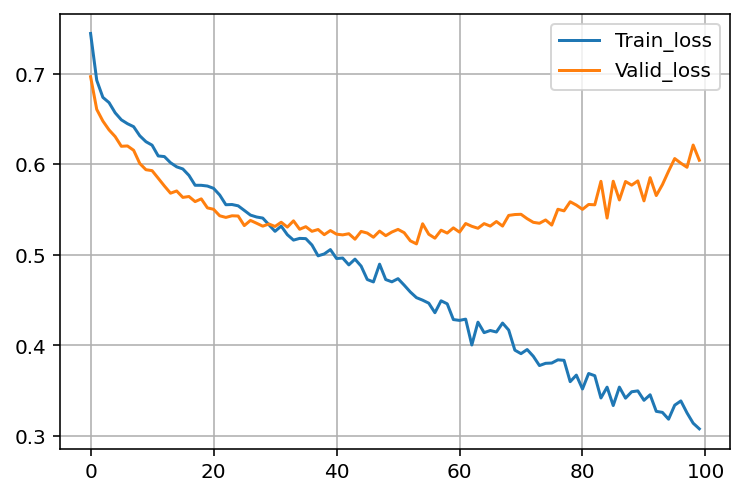

In [41]:
plt.plot(my_SRNN.loss_during_training,label='Train_loss')
plt.plot(my_SRNN.valid_loss_during_training,label='Valid_loss')
plt.legend()
plt.grid()

Obtenemos la configuración con menor error de valdiación ...

In [33]:
idx_min = np.argsort(my_SRNN.valid_loss_during_training)

In [34]:
idx_min[0]

53

In [35]:
state_dict = torch.load(my_SRNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth')

my_SRNN.load_state_dict(state_dict)

<All keys matched successfully>

Obtenemos accuracy ...

In [36]:
p,a = my_SRNN.predict_proba(docs1=docs_test_1,docs2=docs_test_2,lengths1=l1_test,lengths2=l2_test,Y=y_test)

In [37]:
a

0.73425

La mejora en accuracy es evidente. Veamos la curva ROC ...

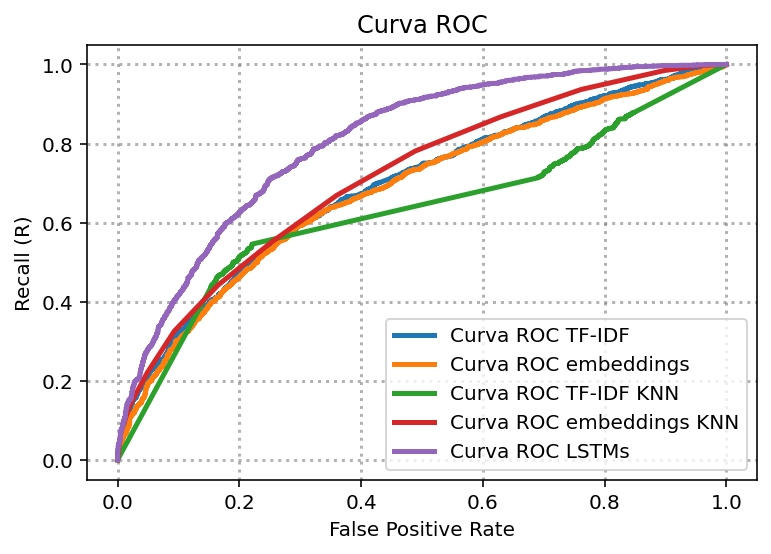

El área bajo la curva ROC de TF-IDF es 0.6915149345335515
El área bajo la curva ROC de embeddings es 0.6828903639440125
El área bajo la curva ROC de TF-IDF con KNN es 0.6306828958248091
El área bajo la curva ROC de embeddings con KNN es 0.7164617643548827
El área bajo la curva ROC de embeddings con LSTMs es 0.8052315886269095


In [39]:
fpr5, recall5, thresholds = metrics.roc_curve(y_test, p, pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC TF-IDF KNN')
plt.plot(fpr4,recall4,lw=2.5,label='Curva ROC embeddings KNN')
plt.plot(fpr5,recall5,lw=2.5,label='Curva ROC LSTMs')
plt.legend(loc=4)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTMs = metrics.roc_auc_score(y_test, p) 


print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de TF-IDF con KNN es {area_roc_tf_idf_KNN}")
print(f"El área bajo la curva ROC de embeddings con KNN es {area_roc_embbedings_KNN}")
print(f"El área bajo la curva ROC de embeddings con LSTMs es {area_roc_LSTMs}")

La mejora es clara. Más si tenemos en cuenta que los parámetros de las redes apenas se han validado. 